Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Text(0,0.5,u'kl_div')

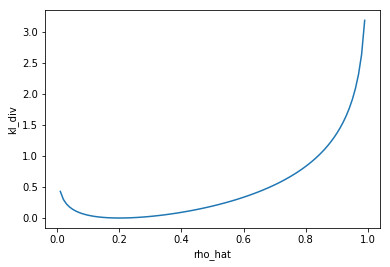

In [2]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)

rho_hat=np.linspace(0+1e-2,1-1e-2,100)
rho=.2
kl_div=rho*np.log(rho/rho_hat)+(1-rho)*np.log((1-rho)/(1-rho_hat))

plt.plot(rho_hat,kl_div)
plt.xlabel("rho_hat")
plt.ylabel("kl_div")



In [12]:
def weight_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)

def bias_variable(shape, name):
    return tf.Variable(tf.zeros(shape = shape), name)

def build_sae():
    W_e_1 = weight_variable([784, 300], "w_e_1")
    b_e_1 = bias_variable([300], "b_e_1")
    h_e_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, W_e_1), b_e_1))

    W_e_2 = weight_variable([300, 30], "w_e_2")
    b_e_2 = bias_variable([30], "b_e_2")
    h_e_2 = tf.nn.sigmoid(tf.add(tf.matmul(h_e_1, W_e_2), b_e_2))

    W_d_1 = weight_variable([30, 300], "w_d_1")
    b_d_1 = bias_variable([300], "b_d_1")
    h_d_1 = tf.nn.sigmoid(tf.add(tf.matmul(h_e_2, W_d_1), b_d_1))

    W_d_2 = weight_variable([300, 784], "w_d_2")
    b_d_2 = bias_variable([784], "b_d_2")
    h_d_2 = tf.nn.sigmoid(tf.add(tf.matmul(h_d_1, W_d_2), b_d_2))
    
    return [h_e_1, h_e_2], [W_e_1, W_e_2, W_d_1, W_d_2], h_d_2

def kl_div(rho,rho_hat):
    invrho=tf.subtract(tf.constant(1.),rho)
    invrhohat=tf.subtract(tf.constant(1.),rho_hat)
    logrho=tf.add(logfunc(rho,rho_hat),logfunc(invrho,invrhohat))
    return logrho

def logfunc(x,x2):
    return tf.multiply(x,tf.log(tf.div(x,x2)))

def plot_n_reconstruct(origin_img, reconstruct_img, n = 10):

    plt.figure(figsize=(2 * 10, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(origin_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruct_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


tf.reset_default_graph()
sess=tf.InteractiveSession()
x=tf.placeholder(tf.float32,shape=[None,784])
h,w,x_reconstruct=build_sae()

alpha=5e-6
beta=7.5e-5

kl_div_loss=reduce(lambda x,y:x+y,map(lambda x: tf.reduce_sum(kl_div(0.02,tf.reduce_mean(x,0))),h))
#kl_div_loss = tf.reduce_sum(kl_div(0.02, tf.reduce_mean(h[0],0)))
l2_loss=reduce(lambda x,y:x+y,map(lambda x: tf.nn.l2_loss(x),w))

loss=tf.reduce_mean(tf.pow(x_reconstruct-x,2))+alpha*l2_loss+beta*kl_div_loss
optimizer=tf.train.AdamOptimizer(0.01).minimize(loss)
init_op=tf.global_variables_initializer()

sess.run(init_op)

for i in range(20000):
    batch=mnist.train.next_batch(60)
    if i%100==0:
        print("step %d, loss %g"%(i,loss.eval(feed_dict={x:mnist.test.images})))
    optimizer.run(feed_dict={x:batch[0]})

print("final loss %g" % loss.eval(feed_dict={x:mnist.test.images}))

step 0, loss 0.286373
step 100, loss 0.0674374
step 200, loss 0.0615314
step 300, loss 0.0570767
step 400, loss 0.054188
step 500, loss 0.050918
step 600, loss 0.0477547
step 700, loss 0.0464184
step 800, loss 0.0452055
step 900, loss 0.0433097
step 1000, loss 0.0421848
step 1100, loss 0.0411413
step 1200, loss 0.0409185
step 1300, loss 0.0402528
step 1400, loss 0.0404098
step 1500, loss 0.0399852
step 1600, loss 0.0397798
step 1700, loss 0.0393933
step 1800, loss 0.0391789
step 1900, loss 0.0390055
step 2000, loss 0.0392055
step 2100, loss 0.0386089
step 2200, loss 0.0384145
step 2300, loss 0.0385261
step 2400, loss 0.0384
step 2500, loss 0.0383109
step 2600, loss 0.0379556
step 2700, loss 0.0382452
step 2800, loss 0.038108
step 2900, loss 0.0376629
step 3000, loss 0.0377287
step 3100, loss 0.0373832
step 3200, loss 0.0375156
step 3300, loss 0.0374863
step 3400, loss 0.037567
step 3500, loss 0.0374164
step 3600, loss 0.0372192
step 3700, loss 0.0370629
step 3800, loss 0.0371314
step 3

In [13]:
for h_i in h:
    print("average output activation value %g" % 
          tf.reduce_mean(h_i).eval(feed_dict={x:mnist.test.images}))


average output activation value 0.0521203
average output activation value 0.392867


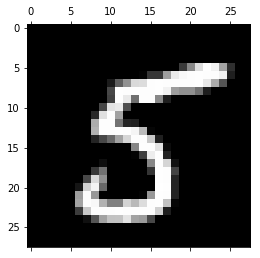

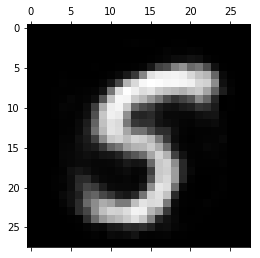

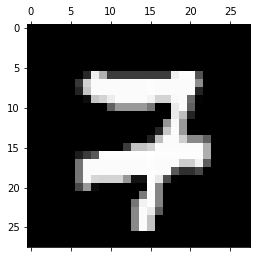

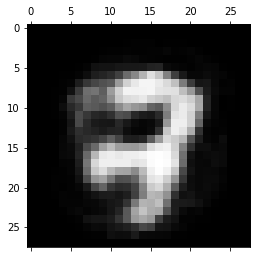

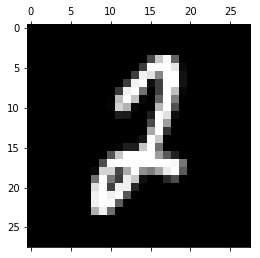

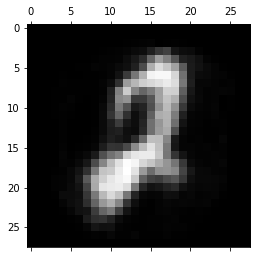

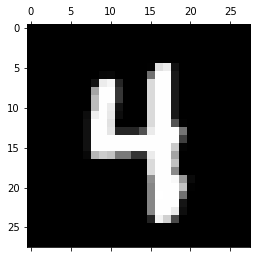

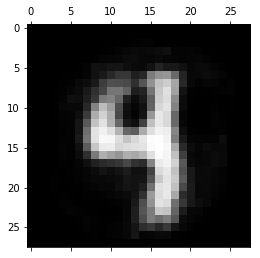

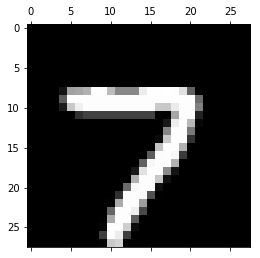

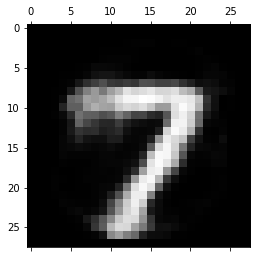

In [15]:
trainimg=mnist.train.images
trainlabel=mnist.train.labels
output_nd=x_reconstruct.eval(feed_dict={x:mnist.train.images})

for i in [0,1,2,3,4]:
    curr_img=np.reshape(trainimg[i,:],(28,28))
    ae_img=np.reshape(output_nd[i,:],(28,28))
    curr_label=np.argmax(trainlabel[i,:])
    plt.matshow(curr_img,cmap=plt.get_cmap('gray'))
    plt.matshow(ae_img,cmap=plt.get_cmap('gray'))